In [132]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding, SpatialDropout1D,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
)

In [133]:
news=pd.read_csv("Combined_News_DJIA.csv")



In [134]:
# This is roughly a 80%/20% split by using data from 2008-08-08 to 2014-12-31 as the training Set, and data from 2015-01-02 to 2016-07-01 as the testing Set
train = news[news["Date"] < "20150101"]
y_train = train["Label"]

test = news[news["Date"] > "20141231"]
y_test = test["Label"]

In [135]:
df_train = train.iloc[:, 2:27]
# replace non-alphabetic characters with spaces
df_train.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

# Convertng headlines to lower case
for i in df_train.columns:
    df_train[i] = df_train[i].str.lower()
df_train.head(1)


,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,b georgia downs two russian warplanes as cou...,b breaking musharraf to be impeached,b russia today columns of troops roll into so...,b russian tanks are moving towards the capital...,b afghan children raped with impunity u n ...,b russian tanks have entered south ossetia...,b breaking georgia invades south ossetia rus...,b the enemy combatent trials are nothing but...,b georgian troops retreat from s osettain cap...,b did the u s prep georgia for war with russia,...,b georgia invades south ossetia if russia ge...,b al qaeda faces islamist backlash,b condoleezza rice the us would not act to p...,b this is a busy day the european union has ...,b georgia will withdraw soldiers from ir...,b why the pentagon thinks attacking iran is a ...,b caucasus in crisis georgia invades south os...,b indian shoe manufactory and again in a se...,b visitors suffering from mental illnesses ban...,b no help for mexico s kidnapping surge


In [136]:
# Combine 25 headlines into a single paragraph for each row
x_train = []
for row in range(0, len(df_train.index)):
    x_train.append(" ".join(str(x) for x in df_train.iloc[row, 0:25]))

In [137]:
## Perform the prediction on the test set
x_test = []
for row in range(0, len(test.index)):
    x_test.append(" ".join(str(x) for x in test.iloc[row, 2:27]))

In [138]:
start_time = time.time()

In [139]:
# set the max of features to 4000
features= 4000
tok = Tokenizer(num_words=features)
tok.fit_on_texts(x_train)
size= len(tok.word_index) + 1

In [140]:
encoded = tok.texts_to_sequences(x_train)
padded = pad_sequences(encoded, maxlen=10 )

In [141]:
# The document is padded with the maximum lenth of 10
max_len=10
model=Sequential()
model.add(Embedding(size, 128, input_length=max_len))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128,recurrent_dropout=0.3,dropout=0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 10, 128)           4147712   
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 10, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,279,425
Trainable params: 4,279,425
Non-trainable params: 0
_________________________________________________________________


In [142]:
result = model.fit(padded,y_train,batch_size=32,validation_split=0.2, epochs=10)

Epoch 1/10
47/47 [==============================] - 2s 29ms/step - loss: 0.6913 - accuracy: 0.5376 - val_loss: 0.6928 - val_accuracy: 0.5067
Epoch 2/10
47/47 [==============================] - 1s 26ms/step - loss: 0.6462 - accuracy: 0.6114 - val_loss: 0.7301 - val_accuracy: 0.5094
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.4417 - accuracy: 0.8027 - val_loss: 0.8948 - val_accuracy: 0.5121
Epoch 4/10
47/47 [==============================] - 1s 27ms/step - loss: 0.2528 - accuracy: 0.8987 - val_loss: 1.2394 - val_accuracy: 0.5228
Epoch 5/10
47/47 [==============================] - 1s 28ms/step - loss: 0.1509 - accuracy: 0.9477 - val_loss: 1.2710 - val_accuracy: 0.5228
Epoch 6/10
47/47 [==============================] - 1s 30ms/step - loss: 0.0868 - accuracy: 0.9718 - val_loss: 1.8683 - val_accuracy: 0.5282
Epoch 7/10
47/47 [==============================] - 1s 26ms/step - loss: 0.0428 - accuracy: 0.9859 - val_loss: 2.0502 - val_accuracy: 0.5121
Epoch 8/10
47

In [143]:
end_time = time.time() - start_time
print('Training time: {:.2f} s'.format(end_time))

Training time: 14.71 s


In [144]:
predicted = tok.texts_to_sequences(x_test)
predicted = pad_sequences(predicted,maxlen=10)
predicted = model.predict(predicted).round()

# get the roc_auc_score for model

roc_auc_score(y_test, predicted)

12/12 [==============================] - 0s 2ms/step


0.5057963709677419

In [145]:
accuracy_score(y_test, predicted)

0.5052910052910053

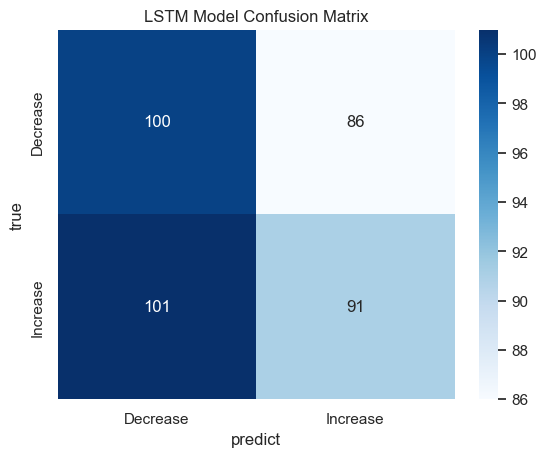

In [146]:
matrix = confusion_matrix(y_test, predicted)

# Plot the confusion matrix heatmap
import seaborn as sns
sns.set()
confusion_matrix_name = pd.DataFrame(matrix, index=['Decrease', 'Increase'], columns=['Decrease', 'Increase'])
f,ax=plt.subplots()
sns.heatmap(confusion_matrix_name,annot=True, fmt='.20g', cmap=plt.cm.Blues,ax=ax) 

ax.set_title('LSTM Model Confusion Matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')
# plt.savefig('LSTM_real_confusion_matrix.png')

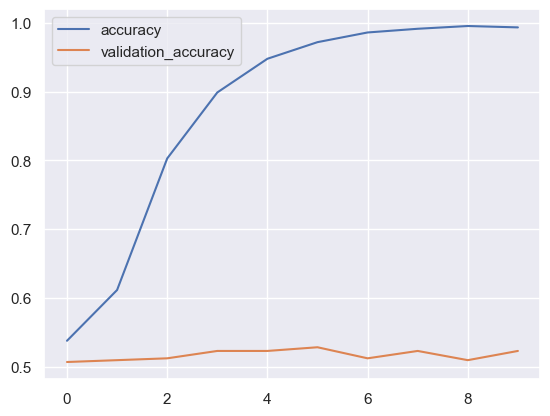

In [147]:
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label='validation_accuracy')
plt.legend()
plt.show()

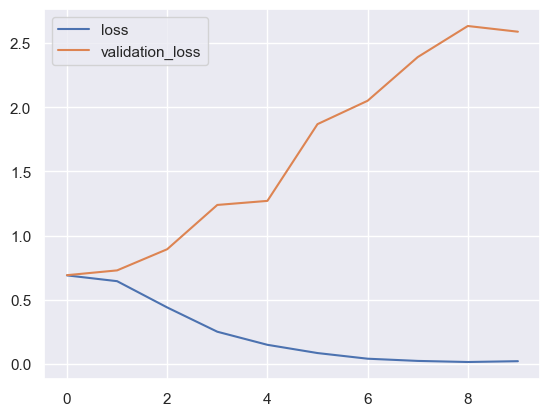

In [148]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='validation_loss')
plt.legend()

plt.show()